In [1]:
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt
sym.init_printing(use_latex="mathjax")
from scipy.optimize import root
# scipy.optimize.root

In [347]:
v=0.25
lbg=0.1
k=0.0003
kbg=0.4
I0=300
mumax=1.2
romax=0.2
m=15
qmax=0.04
qmin=0.004
h=120
d=10 # But says v=d for q=Rb1/A1 to be used?


N=1000
zmax = 30
z = np.linspace(0,zmax,N)    # (start,stop, number of nodes)

# as specified A1(0)=100, Rb1(0)=2.2, Rd1=30
A1_guess = 100
Rb1_guess = 5 * ( qmin * A1_guess ) # so q is halfway between qmax and qmin to keep uptake function positive
Rd1_guess = 89.3

A1,Rb1,Rd1 = sym.symbols('A1 Rb1 Rd1')


In [348]:
## Algal nutrient quota (correct as long as v=d in (1))
def q(Rb, A): # don't need this
    return Rb/A
    
# Specific algal growth rate p is an increasing, saturating function of light intensity I and algal nutrient quota q
def p(I,q, mumax=mumax, qmin=qmin, h=h):
    return mumax * (1 - qmin/q) * (I/(h + I))

# Specific algal nutrient uptake rate (transforms dissolved into bound nutrients)
def ro(q, Rd, romax = romax, qmax = qmax, qmin=qmin, m=m):
    return romax * (qmax-q)/(qmax-qmin) * ( Rd/(m + Rd) )

In [349]:
def plankton_equations(y):
    A1 = y[0]
    A2 = y[1]
    Rb1 = y[2]
    Rb2 = y[3]
    Rd1 = y[4]
    Rd2 = y[5]
    I = y[6]
    q = Rb1/A1
    
    derivatives = np.array((A2,
                     (v*A2 + lbg*A1 - p(I,q)*A1)/d,
                     Rb2,
                     (v*Rb2 + lbg*Rb1 - ro(q,Rd1)*A1)/d,
                     Rd2,
                     (ro(q,Rd1)*A1 - lbg*Rb1)/d,
                     -(k*A1 + kbg)*I))
    return derivatives

initial_guess = np.array([])
initial_conditions = np.array([A1_guess,
                              v*A1_guess/d,
                              Rb1_guess,
                              v*Rb1_guess/d,
                              Rd1_guess,
                              0,
                              I0])



In [350]:
def one_step_rk4(f, xvinit, Tmax, N):
    xv = xvinit                            # set first ROW to the initial conditions
    h = Tmax / N                           # step size
    k1 = f(xv)
    k2 = f(xv + h/2.0*k1)
    k3 = f(xv + h/2.0*k2)
    k4 = f(xv + h*k3)
    next_step = xv[0] + h/6.0 *( k1 + 2*k2 + 2*k3 + k4)
    return next_step

In [351]:
def rk4(f, xvinit, Tmax, N):               # N=number of steps
    T = np.linspace(0, Tmax, N+1)
    xv = np.zeros( (len(T), len(xvinit)) ) # matrix with # cols=# initial conditions
    xv[0] = xvinit                         # set first ROW = initial conditions
    h = Tmax / N                           # step size
    for i in range(N):
        k1 = f(xv[i])
        k2 = f(xv[i] + h/2.0*k1)
        k3 = f(xv[i] + h/2.0*k2)
        k4 = f(xv[i] + h*k3)
        xv[i+1] = xv[i] + h/6.0 *( k1 + 2*k2 + 2*k3 + k4)
    return T, xv

In [352]:
# To see how first 2 steps behave
first_step = one_step_rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)
second_step = one_step_rk4(lambda x: plankton_equations(x), first_step, zmax, N)

In [353]:
z, derivs = rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)

In [354]:
results = pd.DataFrame(derivs)
results.columns = [['A1','A2','Rb1','Rb2','Rd1','Rd2','I']]
results = results.set_index(z)
results.index.name = 'z'
results['R'] = results.loc[:,['Rb1','Rd1']].sum(axis=1)
results['q'] = np.array(results.Rb1) / np.array(results.A1)

Text(0.5, 0, 'z ( m depth in water column of depth 30m )')

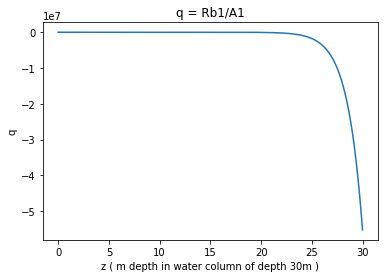

In [355]:
plt.plot(results.q)
plt.title('q = Rb1/A1')
plt.ylabel('q')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

Text(0.5, 0, 'z ( m depth in water column of depth 30m )')

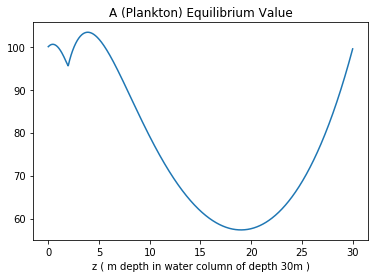

In [356]:
plt.plot(results.A1)
plt.title('A (Plankton) Equilibrium Value')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

Text(0.5, 0, 'z ( m depth in water column of depth 30m )')

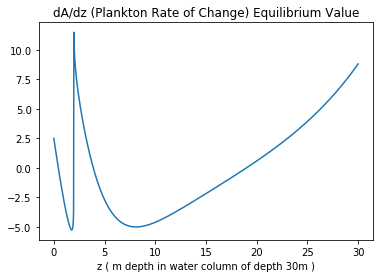

In [357]:
plt.plot(results.A2)
plt.title('dA/dz (Plankton Rate of Change) Equilibrium Value')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

Text(0.5, 0, 'z ( m depth in water column of depth 30m )')

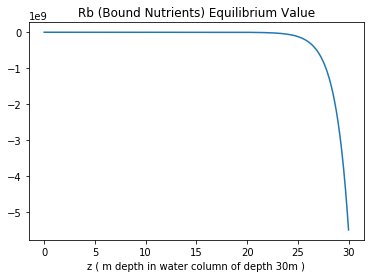

In [358]:
plt.plot(results.Rb1)
plt.title('Rb (Bound Nutrients) Equilibrium Value')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

Text(0.5, 0, 'z ( m depth in water column of depth 30m )')

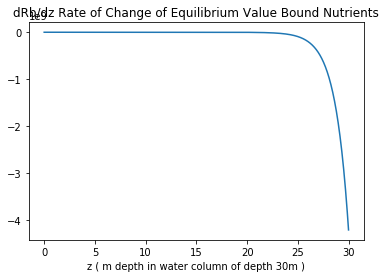

In [359]:
plt.plot(results.Rb2)
plt.title('dRb/dz Rate of Change of Equilibrium Value Bound Nutrients')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

Text(0.5, 0, 'z ( m depth in water column of depth 30m )')

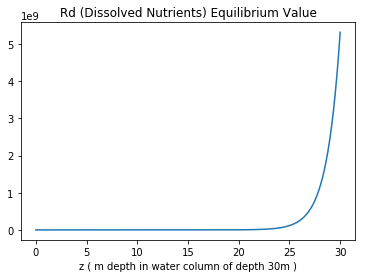

In [360]:
plt.plot(results.Rd1)
plt.title('Rd (Dissolved Nutrients) Equilibrium Value')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

Text(0.5, 0, 'z ( m depth in water column of depth 30m )')

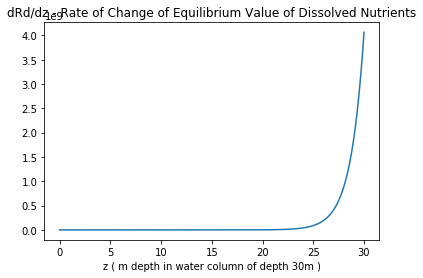

In [361]:
plt.plot(results.Rd2)
plt.title('dRd/dz - Rate of Change of Equilibrium Value of Dissolved Nutrients')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

Text(0.5, 0, 'z ( m depth in water column of depth 30m )')

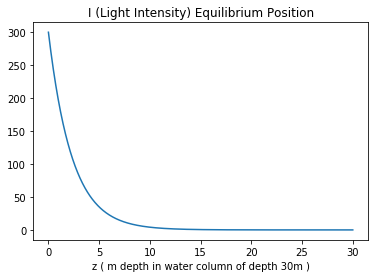

In [362]:
plt.plot(results.I)
plt.title('I (Light Intensity) Equilibrium Position')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

## For Shooting Method:

In [365]:
def end_values(values_at_zmax_integrated):
    """Creates Robin boundary conditions using values at zmax of integrated function and adds known BCs."""
    
    Rb1_end = values_at_zmax_integrated[1]
    Rd2_end = values_at_zmax_integrated[3]
    values_at_zmax = np.array([0,       # A2
                          d*Rd2_end/v,  # Rb1 Robin Boundary Condition
                          0,            # Rb2
                          v*Rb1_end/v]) # Rd2 Robin Boundary Condition
    return values_at_zmax

def residuals(initial_conditions):
    """Takes initial guess array of length 7 and returns residuals array \ncontaining residuals for A2,Rb1,Rb2,Rd2 and padded with 3 zeroes."""
    
    z, derivs = rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)
    
    residuals = np.zeros(7)
    values_at_zmax_integrated = derivs[N,[2,3,4,6]]       # actual values of A2,Rb1,Rb2,Rd2 obtained through integration
    BCs_at_zmax = end_values(values_at_zmax_integrated)   # expected relationship between values with Robin BCs
    residuals[[2,3,4,6]] = BCs_at_zmax - values_at_zmax_integrated
    
    return residuals

[Notes on method to use ](https://stackoverflow.com/questions/30636988/python-scipy-fsolve-mismatch-between-the-input-and-output-shape-of-the-func-a)

In [ ]:
root(residuals, initial_conditions, method='lm')